# Generate the most likely conformation of an organic molecule

In [114]:
import BioSimSpace as BSS

In [115]:
organic = BSS.Parameters.gaff("c1ccccc1").getMolecule()

# Setting up

In [116]:
box, angles = BSS.Box.truncatedOctahedron(10*BSS.Units.Length.nanometer)
print(box, angles)

[100.0000 A, 100.0000 A, 100.0000 A] [109.4712 degrees, 70.5288 degrees, 70.5288 degrees]


In [117]:
box_min, box_max = organic.getAxisAlignedBoundingBox()
box_size = [y - x for x, y in zip(box_min, box_max)]
padding = 15 * BSS.Units.Length.angstrom
box_length = max(box_size) + 2*padding

In [118]:
solvated = BSS.Solvent.tip3p(molecule=organic, box=3*[box_length])

In [119]:
print(f"solvated = {solvated.charge()}, protein = {organic.charge()}")

solvated = -0.0000e+00 |e|, protein = -0.0000e+00 |e|


# View

In [120]:
view = BSS.Notebook.View(solvated)
view.system()

NGLWidget(gui_style='ngl')

# Simulation

In [121]:
BSS.IO.saveMolecules("solvated", solvated, ["prm7", "rst7"])

['/home/jovyan/solvated.prm7', '/home/jovyan/solvated.rst7']

In [122]:
protocol = BSS.Protocol.Equilibration()
print(protocol)

<BioSimSpace.Protocol.Equilibration: timestep=2.0000 fs, runtime=0.2000 ns, temperature_start=300.0000 K, temperature_end=300.0000 K, pressure=None, report_interval=100, restart_interval=500,restraint=None, force_constant=10.00 kcal_per_mol/angstrom**2>


In [123]:
BSS.Process.engines()

['Amber', 'Gromacs', 'Namd', 'OpenMM', 'Somd']

In [124]:
system = BSS.IO.readMolecules("./solvated*")

In [125]:
protocol = BSS.Protocol.Minimisation(steps=1000)

In [126]:
process = BSS.Process.Amber(system, protocol)

In [127]:
process.workDir()

'/tmp/tmpzxsuomql'

In [128]:
process.exe()

'/srv/conda/envs/notebook/bin/sander'

In [129]:
process.inputFiles()

['/tmp/tmpzxsuomql/amber.cfg',
 '/tmp/tmpzxsuomql/amber.rst7',
 '/tmp/tmpzxsuomql/amber.prm7']

In [130]:
process.start()

BioSimSpace.Process.Amber(<BioSimSpace.System: nMolecules=1362>, BioSimSpace.Protocol.Minimisation(steps=1000), exe='/srv/conda/envs/notebook/bin/sander', name='amber', work_dir='/tmp/tmpzxsuomql', seed=None)

In [212]:
process.isRunning()

True

In [174]:
process.runTime()

0.5183 mins

In [111]:
minimised = process.getSystem()

# Equlibration

In [112]:
protocol = BSS.Protocol.Equilibration(runtime=20*BSS.Units.Time.picosecond,
                                      temperature_start=0*BSS.Units.Temperature.kelvin,
                                      temperature_end=300*BSS.Units.Temperature.kelvin,
                                      restraint=None)

In [113]:
process = BSS.Process.Amber(minimised, protocol).start()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ ❱ 1 process = BSS.Process.Amber(minimised, protocol).start()                                     │
│   2                                                                                              │
│                                                                                                  │
│ /srv/conda/envs/notebook/lib/python3.9/site-packages/BioSimSpace/Process/_amber.py:218 in        │
│ __init__                                                                                         │
│                                                                                                  │
│    215 │   │   """                                                                               │
│    216 │   │                                                                                     │
│    217 │   │   # Call the base class constructor.                                                │
│ ❱  218 │   │   super().__init__(                                                                 │
│    219 │   │   │   system,                                                                       │
│    220 │   │   │   protocol,                                                                     │
│    221 │   │   │   name=name,                                                                    │
│                                                                                                  │
│ /srv/conda/envs/notebook/lib/python3.9/site-packages/BioSimSpace/Process/_process.py:124 in      │
│ __init__                                                                                         │
│                                                                                                  │
│    121 │   │                                                                                     │
│    122 │   │   # Check that the system is valid.                                                 │
│    123 │   │   if not isinstance(system, _System):                                               │
│ ❱  124 │   │   │   raise TypeError(                                                              │
│    125 │   │   │   │   "'system' must be of type 'BioSimSpace._SireWrappers.System'"             │
│    126 │   │   │   )                                                                             │
│    127                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'system' must be of type 'BioSimSpace._SireWrappers.System'

In [103]:
print(process.getTime(), process.getTemperature(), process.getTotalEnergy())

0.0000e+00 ps 0.0200 K -8172.8328 kcal/mol


In [107]:
print(process.getTime().nanoseconds(), process.getTemperature().celsius(), process.getTotalEnergy().kj_per_mol())

0.0000e+00 ns -273.1300 C -3.4195e+04 kJ/mol


# nvt will be used in the NPT simulation

In [301]:
nvt= process.getSystem()

# Ploting curves

In [288]:
plot1 = BSS.Notebook.plot(process.getTime(time_series=True), process.getTemperature(time_series=True))

In [332]:
plot = BSS.Notebook.plot(process.getTime(time_series=True), process.getTotalEnergy(time_series=True))

In [289]:
view = BSS.Notebook.View(process)

In [290]:
view.system()

In [291]:
view.molecule(0)

In [292]:
view.savePDB("equilibrated.pdb", index=0)

# NPT equlibration

In [337]:
protocol = BS.Protocol.Equilibration(runtime=20*BSS.Units.Time.picosecond,
                                      temperature_start=0*BSS.Units.Temperature.kelvin,
                                      temperature_end=300*BSS.Units.Temperature.kelvin,
                                      restraint=None)

In [338]:
process = BS.Process.OpenMM(nvt, protocol).start()

In [339]:
print(process.getTime(), process.getTemperature(), process.getTotalEnergy())

20.0000 ps 271.5792 K -1.9709e+04 kcal/mol


In [365]:
print(process.getTime(), process.getTemperature(), process.getTotalEnergy())

20.0000 ps 271.5792 K -1.9709e+04 kcal/mol


In [366]:
print(process.getTime().nanoseconds(), process.getTemperature().celsius(), process.getTotalEnergy().kj_per_mol())

0.0200 ns -1.5708 C -8.2464e+04 kJ/mol


In [367]:
npt= process.getSystem()

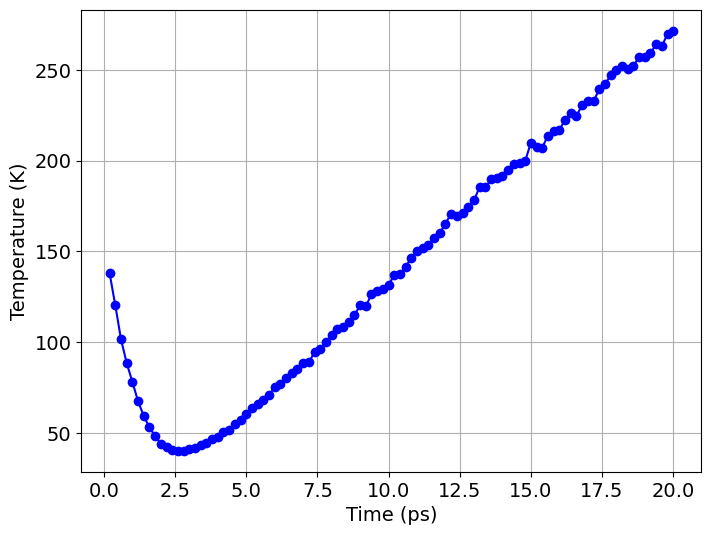

In [368]:
plot1 = BSS.Notebook.plot(process.getTime(time_series=True), process.getTemperature(time_series=True))

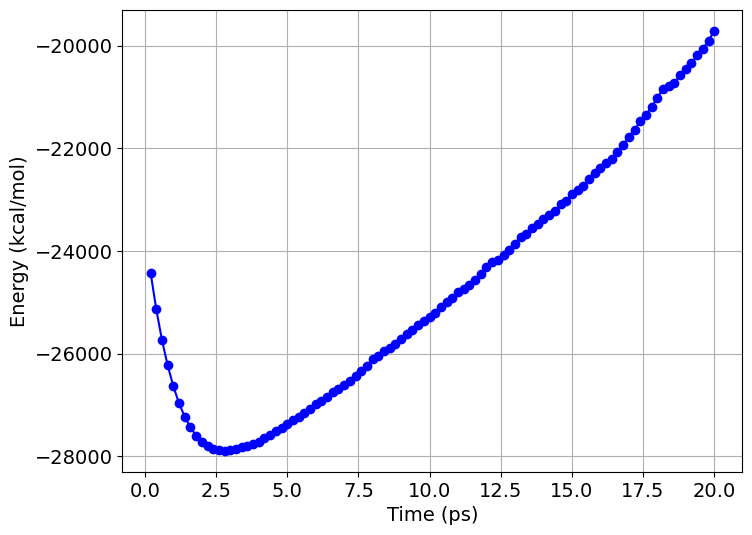

In [369]:
plot = BSS.Notebook.plot(process.getTime(time_series=True), process.getTotalEnergy(time_series=True))

In [370]:
view = BSS.Notebook.View(process)

In [373]:
view.molecule(1)

NGLWidget(gui_style='ngl')

In [374]:
view.savePDB("equilibrated_npt.pdb", index=0)

In [375]:
traj = process.getTrajectory()

In [376]:
traj.nFrames()

20

In [377]:
frames = traj.getFrames()

In [378]:
frames = traj.getFrames([0, -1])

In [379]:
mdtraj = traj.getTrajectory()
type(mdtraj)